# Tirer le meilleur parti de nos objets avec des descripteurs

Ce guide présente un nouveau concept qui est plus avancé dans le développement Python puisqu'il comporte des descripteurs. De plus, les descripteurs ne sont pas familiers aux programmeurs d'autres langages, il n'y a donc pas d'analogies ou de parallélismes faciles à faire.


Les descripteurs sont une autre caractéristique distinctive de Python qui amène la programmation orientée objet à un autre niveau, et leur potentiel permet aux utilisateurs de créer des abstractions plus puissantes et réutilisables. La plupart du temps, le plein potentiel des descripteurs est observé dans les bibliothèques ou les frameworks.

Dans ce guide, nous atteindrons les objectifs suivants liés aux descripteurs :

* Comprendre ce que sont les descripteurs, comment ils fonctionnent et comment les mettre en œuvre efficacement

* Analyser les deux types de descripteurs (descripteurs de données et non-données) en fonction de leur différences conceptuelles et détails de mise en œuvre

* Réutiliser le code efficacement grâce aux descripteurs

* Analyser des exemples de bonnes utilisations des descripteurs et comment en tirer parti pour nos bibliothèques d'API

## Un premier regard sur les descripteurs

Tout d'abord, nous explorerons l'idée principale derrière les descripteurs pour comprendre leur mécanique et leur fonctionnement interne. Une fois cela clair, il sera plus facile d'assimiler le fonctionnement des différents types de descripteurs, que nous explorerons dans la section suivante. Une fois que nous aurons une compréhension générale de l'idée derrière les descripteurs, nous examinerons un exemple où leur utilisation donne nous une implémentation plus propre et plus Pythonic.

## La machinerie derrière les descripteurs

La façon dont les descripteurs fonctionnent n'est pas si compliquée, mais le problème avec eux est qu'il y a beaucoup de mises en garde à prendre en considération, donc les détails de mise en œuvre sont de la plus haute importance ici.

Pour implémenter des descripteurs, nous avons besoin d'au moins deux classes. Pour cet exemple générique, la classe client tirera parti de la fonctionnalité que nous voulons implémenter dans le descripteur (ce n'est généralement qu'une classe de modèle de domaine, une abstraction régulière que nous créons pour notre solution), et la classe de descripteur implémentera la logique de le descripteur lui-même.

Un descripteur n'est donc qu'un objet qui est une instance d'une classe qui implémente le protocole de descripteur. Cela signifie que l'interface de cette classe doit contenir au moins une des méthodes magiques suivantes (partie du protocole de descripteur à partir de Python 3.6+) :

* \_\_get\_\_
*  \_\_set_\_
*   \_\_delete__
*   \_\_set_name__

Aux fins de cette introduction initiale de haut niveau, les conventions de nommage suivantes seront utilisées :

* **ClientClass**: L'abstraction au niveau du domaine qui tirera parti de la fonctionnalité à implémenter par le descripteur. Cette classe est dite cliente du descripteur. Cette classe contient un attribut de classe (nommé descripteur par cette convention), qui est une instance de DescriptorClass.

* **DescriptorClass**: La classe qui implémente le descripteur lui-même. Cette classe devrait implémenter certaines des méthodes magiques susmentionnées qui impliquent le protocole de descripteur

* **client**: Une instance de ClientClass client = ClientClass()

* **descriptor**: Une instance de DescriptorClass.
  
  descriptor = DescriptorClass(). Cet objet est un attribut de classe placé dans ClientClass.


  Cette relation est illustrée à la figure
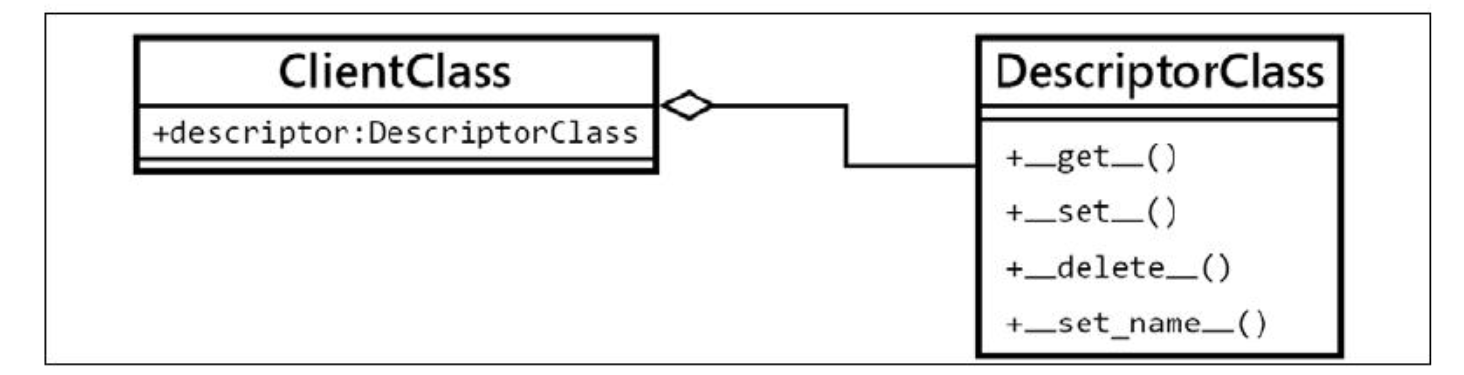

Une observation très importante à garder à l'esprit est que pour que ce protocole fonctionne, l'objet descripteur doit être défini comme un attribut de classe. La création de cet objet en tant qu'attribut d'instance ne fonctionnera pas, il doit donc être dans le corps de la classe et non dans la méthode \_\_init__.


      Placez toujours l'objet descripteur en tant qu'attribut de classe !

Sur une note un peu plus critique, les lecteurs peuvent également noter qu'il est possible d'implémenter partiellement le protocole de descripteur — toutes les méthodes ne doivent pas toujours être définies ; au lieu de cela, nous ne pouvons mettre en œuvre que ceux dont nous avons besoin, comme nous le verrons bientôt.

Donc, maintenant nous avons la structure en place - nous savons quels éléments sont définis et comment ils interagissent. Nous avons besoin d'une classe pour le descripteur, d'une autre classe qui consommera la logique du descripteur, qui, à son tour, aura un objet descripteur (une instance de DescriptorClass) comme attribut de classe, et des instances de ClientClass qui suivront le protocole de descripteur lorsque nous appelons l'attribut nommé descripteur. Mais maintenant quoi ? Comment tout cela se met-il en place au moment de l'exécution ?


Normalement, lorsque nous avons une classe régulière et que nous accédons à ses attributs, nous obtenons simplement les objets tels que nous les attendons, et même leurs propriétés, comme dans l'exemple suivant :

In [1]:
class Attribute:
  value = 42


class Client:
  attribute = Attribute()
  

Client().attribute

Mais, dans le cas des descripteurs, quelque chose de différent se produit. Lorsqu'un objet est défini comme un attribut de classe (et celui-ci est un descripteur), lorsqu'un client demande cet attribut, au lieu d'obtenir l'objet lui-même (comme on pourrait s'y attendre dans l'exemple précédent), nous obtenons le résultat d'avoir appelé la méthode magique \_\_get__.

Commençons par un code simple qui n'enregistre que des informations sur le contexte et renvoie le même objet client :

In [2]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class DescriptorClass:
    def __get__(self, instance, owner):
        if instance is None:
            return self
        logger.info(
            "Call: %s.__get__(%r, %r)",
            self.__class__.__name__,
            instance,
            owner,
        )
        return instance


class ClientClass:
    descriptor = DescriptorClass()

Lors de l'exécution de ce code et de la demande de l'attribut descripteur d'une instance de ClientClass, nous découvrirons que nous n'obtenons en fait pas d'instance de DescriptorClass, mais quel que soit le retour de sa méthode \_\_get__()

In [3]:
client = ClientClass()
client.descriptor

INFO:__main__:Call: DescriptorClass.__get__(<__main__.ClientClass object at 0x7fe80f9cd350>, <class '__main__.ClientClass'>)


Remarquez comment la ligne de journalisation, placée sous la méthode \_\_get__, a été appelée au lieu de simplement renvoyer l'objet que nous avons créé. Dans ce cas, nous avons fait en sorte que cette méthode renvoie le client lui-même, faisant ainsi une vraie comparaison de la dernière instruction. Les paramètres de cette méthode sont expliqués plus en détail dans les sous-sections suivantes, alors ne vous en souciez pas pour l'instant. Le point crucial de cet exemple est de comprendre que la recherche d'attributs se comporte différemment lorsque l'un de ces attributs est un descripteur (dans ce cas, car il a une méthode \_\_get__).

À partir de cet exemple simple mais démonstratif, nous pouvons commencer à créer des abstractions plus complexes et de meilleurs décorateurs car la note importante ici est que nous avons un nouvel outil (puissant) avec lequel travailler. Remarquez comment cela change le flux de contrôle du programme d'une manière complètement différente. Avec cet outil, nous pouvons faire abstraction de toutes sortes de logiques derrière la méthode \_\_get__ et faire en sorte que le descripteur exécute de manière transparente toutes sortes de transformations sans même que les clients s'en rendent compte. Cela amène l'encapsulation à un nouveau niveau

## Exploration de chaque méthode du protocole descripteur

Jusqu'à présent, nous avons vu pas mal d'exemples de descripteurs en action, et nous avons eu une idée de leur fonctionnement. Ces exemples nous ont donné un premier aperçu de la puissance des descripteurs, mais vous vous posez peut-être des questions sur certains détails de mise en œuvre et idiomes dont nous n'avons pas abordé les explications.

Comme les descripteurs ne sont que des objets, ces méthodes prennent self comme premier paramètre. Pour tous, cela signifie simplement l'objet descripteur lui-même.

Dans cette section, nous allons explorer en détail chaque méthode du protocole de descripteur, en expliquant ce que signifie chaque paramètre et comment ils sont destinés à être utilisés.

## La méthode get

La signature de cette méthode magique est la suivante :\_\_get__(self, instance, owner) Le premier paramètre, instance, fait référence à l'objet à partir duquel le descripteur est appelé. Dans notre premier exemple, cela signifierait l'objet client. Le paramètre owner est une référence à la classe de cet objet, qui, suivant notre exemple (de la figure), serait ClientClass.

À partir du paragraphe précédent, nous pouvons conclure que le paramètre nommé instance dans la signature de \_\_get__ est l'objet sur lequel le descripteur agit et que propriétaire est la classe de l'instance. Le lecteur avisé pourrait se demander pourquoi la signature est ainsi définie. Après tout, la classe peut être extraite directement de l'instance (owner = instance.__class__). Il existe un cas limite : lorsque le descripteur est appelé à partir de la classe (ClientClass) et non de l'instance (client), la valeur de l'instance est None, mais nous pouvons toujours vouloir effectuer un traitement dans ce cas. C'est pourquoi Python choisit de passer la classe en tant que paramètre différent.

Avec le code simple suivant, nous pouvons démontrer la différence entre un descripteur appelé depuis la classe ou depuis une instance. Dans ce cas, la méthode \_\_get__ fait deux choses distinctes pour chaque cas :

In [4]:
class DescriptorClass:
    def __get__(self, instance, owner):
        if instance is None:
            return f"{self.__class__.__name__}.{owner.__name__}"
        return f"value for {instance}"


class ClientClass:
    """
    >>> ClientClass.descriptor
    'DescriptorClass.ClientClass'
    >>> ClientClass().descriptor  # doctest: +ELLIPSIS
    'value for <descriptors_methods_1.ClientClass object at 0x...>'
    """

    descriptor = DescriptorClass()

Lorsque nous l'appelons directement depuis ClientClass, il fera une chose, qui consiste à composer un espace de noms avec les noms des classes :

In [5]:
ClientClass.descriptor

'DescriptorClass.ClientClass'

Et puis si nous l'appelons à partir d'un objet que nous avons créé, il renverra l'autre message à la place :

In [6]:
ClientClass().descriptor

'value for <__main__.ClientClass object at 0x7fe80f9c3910>'

En général, à moins que nous ayons vraiment besoin de faire quelque chose avec le paramètre propriétaire, l'idiome le plus courant consiste simplement à renvoyer le descripteur lui-même lorsque l'instance est None. En effet, lorsque les utilisateurs appellent le descripteur de la classe, ils s'attendent probablement à obtenir le descripteur lui-même, donc cela a du sens. Mais bien sûr, cela dépend vraiment de l'exemple (plus loin dans le guide, nous verrons différents usages avec leurs explications).

## La méthode Set

La signature de cette méthode est la suivante :__set__(self, instance, value)Cette méthode est appelée lorsque nous essayons d'affecter quelque chose à un descripteur. Il est activé avec des instructions telles que les suivantes, dans lesquelles un descripteur est un objet qui implémente __set__(). 

Le paramètre d'instance, dans ce cas, serait client, et la valeur serait la chaîne "value": client.descriptor = "value"

Vous pouvez noter une certaine similitude entre ce comportement et le décorateur @property.setter des guide précédents, sur lequel l'argument de la fonction setter était la valeur de droite de l'instruction (dans ce cas la chaîne "value"). Nous y reviendrons plus tard dans le guide.


Si client.descriptor n'implémente pas \_\_set__(), alors "value" (n'importe quel objet sur le côté droit de l'instruction) remplacera entièrement le descripteur.


    Soyez prudent lorsque vous attribuez une valeur à un attribut qui est un
    descripteur. Assurez-vous qu'il implémente la méthode __set__ et que nous
    ne causons pas d'effet secondaire indésirable


Par défaut, l'utilisation la plus courante de cette méthode consiste simplement à stocker des données dans un objet. Néanmoins, nous avons vu jusqu'à présent à quel point les descripteurs sont puissants et que nous pouvons en tirer parti, par exemple, si nous devions créer des objets de validation génériques qui peuvent être appliqués plusieurs fois (encore une fois, c'est quelque chose que si nous ne abstrait, nous pourrions finir par répéter plusieurs fois dans les méthodes de définition des propriétés).

La liste suivante illustre comment nous pouvons tirer parti de cette méthode afin de créer des objets de validation génériques pour les attributs, qui peuvent être créés dynamiquement avec des fonctions pour valider les valeurs avant de les affecter à l'objet :

In [9]:
from typing import Callable, Any


class Validation:
    """A configurable validation callable."""

    def __init__(
        self, validation_function: Callable[[Any], bool], error_msg: str
    ) -> None:
        self.validation_function = validation_function
        self.error_msg = error_msg

    def __call__(self, value):
        if not self.validation_function(value):
            raise ValueError(f"{value!r} {self.error_msg}")


class Field:
    """A class attribute with validation functions configured over it."""

    def __init__(self, *validations):
        self._name = None
        self.validations = validations

    def __set_name__(self, owner, name):
        self._name = name

    def __get__(self, instance, owner):
        if instance is None:
            return self
        return instance.__dict__[self._name]

    def validate(self, value):
        for validation in self.validations:
            validation(value)

    def __set__(self, instance, value):
        self.validate(value)
        instance.__dict__[self._name] = value


class ClientClass:
    descriptor = Field(
        Validation(lambda x: isinstance(x, (int, float)), "is not a number"),
        Validation(lambda x: x >= 0, "is not >= 0"),
    )

Nous pouvons voir cet objet en action dans la liste suivante :

In [10]:
client = ClientClass()
client.descriptor = 42
client.descriptor

42

In [11]:
client.descriptor = -42

ValueError: ignored

L'idée est que quelque chose que nous placerions normalement dans une propriété peut être abstrait dans un descripteur et être réutilisé plusieurs fois. Dans ce cas, la méthode \_\_set__() ferait ce que @property.setter aurait fait. Il s'agit d'un mécanisme plus générique que d'utiliser des propriétés, car, comme nous le verrons plus tard, les propriétés sont un cas particulier de descripteurs.

## La méthode de delete

La signature de la méthode delete est plus simple et ressemble à ceci :

\_\_delete__(self, instance)

Cette méthode est appelée avec l'instruction suivante, dans laquelle self serait l'attribut descripteur et instance serait l'objet client dans cet exemple :



In [12]:
del client.descriptor

AttributeError: ignored

Dans l'exemple suivant, nous utilisons cette méthode pour créer un descripteur dans le but de vous empêcher de supprimer des attributs d'un objet sans les privilèges administratifs requis. Remarquez comment, dans ce cas, le descripteur a une logique qui est utilisée pour prédire avec les valeurs de l'objet qui l'utilise, au lieu de différents objets associés :

In [14]:
class ProtectedAttribute:
    def __init__(self, requires_role=None) -> None:
        self.permission_required = requires_role
        self._name = None

    def __set_name__(self, owner, name):
        self._name = name

    def __set__(self, user, value):
        if value is None:
            raise ValueError(f"{self._name} can't be set to None")
        user.__dict__[self._name] = value

    def __delete__(self, user):
        if self.permission_required in user.permissions:
            user.__dict__[self._name] = None
        else:
            raise ValueError(
                f"User {user!s} doesn't have {self.permission_required} "
                "permission"
            )


class User:
    """Only users with "admin" privileges can remove their email address."""

    email = ProtectedAttribute(requires_role="admin")

    def __init__(
        self, username: str, email: str, permission_list: list = None
    ) -> None:
        self.username = username
        self.email = email
        self.permissions = permission_list or []

    def __str__(self):
        return self.username

Avant de voir des exemples du fonctionnement de cet objet, il est important de faire une remarque sur certains des critères de ce descripteur. Notez que la classe User requiert le nom d'utilisateur et l'e-mail comme paramètres obligatoires. Selon sa méthode \_\_init__, il ne peut pas être un utilisateur s'il n'a pas d'attribut email. Si nous devions supprimer cet attribut et l'extraire entièrement de l'objet, nous créerions un objet incohérent, avec un état intermédiaire invalide qui ne correspond pas à l'interface définie par la classe User. Des détails comme celui-ci sont vraiment importants, afin d'éviter les problèmes. Un autre objet s'attend à fonctionner avec cet utilisateur, et il s'attend également à ce qu'il ait un attribut de courrier électronique.

Pour cette raison, il a été décidé que la "suppression" d'un e-mail le définirait simplement sur Aucun, et c'est la partie de la liste de code qui est en gras. Pour la même raison, nous devons interdire à quelqu'un d'essayer de lui attribuer une valeur None, car cela contournerait le mécanisme que nous avons placé dans la méthode \_\_delete__.

Ici, nous pouvons le voir en action, en supposant un cas où seuls les utilisateurs disposant de privilèges « admin » peuvent supprimer leur adresse e-mail :

In [15]:
admin = User("root", "root@d.com", ["admin"])
user = User("user", "user1@d.com", ["email", "helpdesk"])
admin.email

'root@d.com'

In [17]:
del admin.email
admin.email is None

True

In [18]:
user.email

'user1@d.com'

In [19]:
user.email = None

ValueError: ignored

In [20]:
del user.email

ValueError: ignored

Ici, dans ce descripteur simple, nous voyons que nous pouvons supprimer l'e-mail des utilisateurs qui contiennent uniquement l'autorisation « admin ». Pour le reste, lorsque nous essayons d'appeler del sur cet attribut, nous obtenons une exception ValueError.

En général, cette méthode du descripteur n'est pas aussi couramment utilisée que les deux précédentes, mais elle est montrée ici par souci d'exhaustivité

## La méthode set name

Il s'agit d'une méthode relativement nouvelle qui a été ajoutée dans Python 3.6, et a cette structure :\_\_set_name__(self, owner, name)

Lorsque nous créons l'objet descripteur dans la classe qui va l'utiliser, nous avons généralement besoin du descripteur pour connaître le nom de l'attribut qu'il va gérer.

Ce nom d'attribut est celui que nous utilisons pour lire et écrire dans \_\_dict__ dans les méthodes \_\_get__ et \_\_set__, respectivement

Avant Python 3.6, le descripteur ne pouvait pas prendre ce nom automatiquement, donc l'approche la plus générale consistait simplement à le transmettre explicitement lors de l'initialisation de l'objet. Cela fonctionne parfaitement, mais cela pose un problème en ce sens qu'il nécessite que nous dupliquions le nom chaque fois que nous voulons utiliser le descripteur pour un nouvel attribut.

Voici à quoi ressemblerait un descripteur typique si nous n'avions pas cette méthode :


In [21]:
class DescriptorWithName:
    """This descriptor requires the name to be explicitly set."""

    def __init__(self, name):
        self.name = name

    def __get__(self, instance, value):
        if instance is None:
            return self
        logger.info("getting %r attribute from %r", self.name, instance)
        return instance.__dict__[self.name]

    def __set__(self, instance, value):
        instance.__dict__[self.name] = value


class ClientClass:
    """
    >>> client = ClientClass()
    >>> client.descriptor = "value"
    >>> client.descriptor
    'value'
    >>> ClientClass.descriptor_2.name
    "a name that doesn't match the attribute"
    """

    descriptor = DescriptorWithName("descriptor")
  


Nous pouvons voir comment le descripteur utilise cette valeur :

In [22]:
client = ClientClass()
client.descriptor = "value"
client.descriptor

INFO:__main__:getting 'descriptor' attribute from <__main__.ClientClass object at 0x7fe80f968d90>


'value'

Maintenant, si l'on voulait éviter d'écrire deux fois le nom de l'attribut (une fois pour la variable affectée à l'intérieur de la classe, et encore une fois comme nom du premier paramètre du descripteur), il faudrait recourir à quelques astuces , comme utiliser un décorateur de classe, ou (pire encore) utiliser une méta-classe.

Dans Python 3.6, la nouvelle méthode \_\_set_name__ a été ajoutée et elle reçoit la classe dans laquelle ce descripteur est créé et le nom qui est donné à ce descripteur. L'idiome le plus courant consiste à utiliser cette méthode pour le descripteur afin qu'il puisse stocker le nom requis dans cette méthode.

Pour la compatibilité, c'est généralement une bonne idée de conserver une valeur par défaut dans la méthode \_\_init__ tout en profitant de \_\_set_name__.


Avec cette méthode, nous pouvons réécrire le descripteur précédent comme suit :

In [23]:
class DescriptorWithName:    
  def __init__(self, name=None):        
    self.name = name    
  
  def __set_name__(self, owner, name):        
    self.name = name    
    ...

\_\_set_name__ est utile pour obtenir le nom de l'attribut auquel le descripteur a été attribué, mais si nous voulions remplacer la valeur, la méthode \_\_init__ aurait toujours la priorité, nous conservons donc la flexibilité.

Même si nous sommes libres de nommer nos descripteurs comme bon nous semble, nous utilisons généralement le nom du descripteur (le nom de l'attribut) comme clé du \_\_dict__ de l'objet client, ce qui signifie qu'il sera interprété comme un attribut. Pour cette raison, essayez de nommer les descripteurs que vous utilisez comme identifiants Python valides.

## Types de descripteurs

Sur la base des méthodes que nous venons d'explorer, nous pouvons faire une distinction importante entre les descripteurs en fonction de leur fonctionnement. Comprendre cette distinction joue un rôle important pour travailler efficacement avec les descripteurs et aidera également à éviter les mises en garde ou les erreurs courantes lors de l'exécution.


Si un descripteur implémente les méthodes __set__ ou __delete__, il est appelé descripteur de données. Sinon, un descripteur qui implémente uniquement __get__ n'est pas un descripteur de données. Notez que __set_name__ n'affecte pas du tout cette classification.


Lorsque vous essayez de résoudre un attribut d'un objet, un descripteur de données aura toujours la priorité sur le dictionnaire de l'objet, alors qu'un descripteur non-données ne le sera pas. Cela signifie que dans un descripteur non-données, si l'objet a une clé sur son dictionnaire avec le même nom que le descripteur, alors cela sera toujours appelé et le descripteur lui-même ne s'exécutera jamais.

A l'inverse, dans un descripteur de données, même s'il existe une clé dans le dictionnaire portant le même nom que le descripteur, celle-ci ne sera jamais utilisée puisque le descripteur lui-même finira toujours par être appelé.


Les deux sections suivantes expliquent cela plus en détail, avec des exemples, pour avoir une idée plus approfondie de ce à quoi s'attendre de chaque type de descripteur.

## Descripteurs non-data

Nous allons commencer avec un descripteur qui implémente uniquement la méthode \_\_get__, et voir comment il est utilisé :



In [24]:
class NonDataDescriptor:    
  def __get__(self, instance, owner):        
    if instance is None:            
      return self        
    return 42
    
class ClientClass:    
  descriptor = NonDataDescriptor()


Comme d'habitude, si on demande le descripteur, on obtient le résultat de sa méthode __get__ :

In [25]:
client = ClientClass()
client.descriptor

42

Mais si nous changeons l'attribut descripteur en quelque chose d'autre, nous perdons l'accès à cette valeur et obtenons ce qui lui a été assigné à la place :

In [26]:
client.descriptor = 43
client.descriptor

43

Maintenant, si nous supprimons le descripteur et le redemandons, voyons ce que nous obtenons :

In [27]:
del client.descriptor
client.descriptor

42

Revenons en arrière sur ce qui vient de se passer. Lorsque nous avons créé l'objet client pour la première fois, l'attribut descripteur se trouvait dans la classe, pas dans l'instance, donc si nous demandons le dictionnaire de l'objet client, il sera vide :

In [28]:
vars(client)

{}

Et puis, quand on demande l'attribut .descriptor, il ne trouve aucune clé dans client.__dict__ nommé "descriptor", donc il va dans la classe, où il le trouvera ... mais seulement en tant que descripteur, d'où la raison pour laquelle il renvoie le résultat de la méthode __get__.

 Mais ensuite, nous changeons la valeur de l'attribut .descriptor en quelque chose d'autre, et cela définit la valeur 99 dans le dictionnaire de l'instance, ce qui signifie que cette fois, cela ne le fera pas. être vide :

In [29]:
client.descriptor = 99
vars(client)

{'descriptor': 99}

Ainsi, lorsque nous demandons l'attribut .descriptor ici, il le recherchera dans l'objet (et cette fois, il le trouvera car il existe une clé nommée descriptor dans l'attribut \_\_dict__ de l'objet, comme nous le montre le résultat vars ), et le retourner sans avoir à le chercher dans la classe. Pour cette raison, le protocole descripteur n'est jamais invoqué, et la prochaine fois que nous demanderons cet attribut, il renverra à la place la valeur avec laquelle nous l'avons remplacé (99)

Ensuite, nous supprimons cet attribut en appelant del, et ce que cela fait est de supprimer la clé nommée "descriptor" du dictionnaire de l'objet, nous laissant dans le premier scénario, où il va par défaut à la classe où le descripteur le protocole sera déclenché :

In [30]:
del client.descriptor
vars(client)

{}

Cela signifie que si nous définissons l'attribut du descripteur sur autre chose, nous pourrions accidentellement le casser. Pourquoi? 

Parce que le descripteur ne gère pas l'action de suppression (certains d'entre eux n'en ont pas besoin). C'est ce qu'on appelle un descripteur sans données car il n'implémente pas la méthode magique \_\_set__, comme nous le verrons dans l'exemple suivant:


## Data descriptors

Voyons maintenant la différence entre l'utilisation d'un descripteur de données. Pour cela, nous allons créer un autre descripteur simple qui implémente la méthode \_\_set__ :

In [31]:
class DataDescriptor:    
  def __get__(self, instance, owner):        
    if instance is None:            
      return self        
    return 42    
  
  def __set__(self, instance, value):        
    logger.debug("setting %s.descriptor to %s", instance, value)        
    instance.__dict__["descriptor"] = value

class ClientClass:    
  descriptor = DataDescriptor()

Voyons ce que renvoie la valeur du descripteur :

In [32]:
client = ClientClass()
client.descriptor

42

Maintenant, essayons de changer cette valeur en quelque chose d'autre, et voyons ce qu'elle renvoie à la place :

In [33]:
client.descriptor = 99
client.descriptor

42

La valeur renvoyée par le descripteur n'a pas changé. Mais lorsque nous lui attribuons une valeur différente, elle doit être définie sur le dictionnaire de l'objet (comme c'était le cas auparavant) :

In [35]:
vars(client)

{'descriptor': 99}

In [36]:
client.__dict__["descriptor"]

99

Ainsi, la méthode \_\_set__() a été appelée, et en effet elle a fixé la valeur au dictionnaire de l'objet, seulement cette fois, lorsque nous demandons cet attribut, au lieu d'utiliser l'attribut \_\_dict__ du dictionnaire, le descripteur a la priorité (car c'est un descripteur prépondérant).

Encore une chose : la suppression de l'attribut ne fonctionnera plus :

In [37]:
del client.descriptor

AttributeError: ignored

La raison est la suivante : étant donné que maintenant le descripteur a toujours la priorité, l'appel de del sur un objet n'essaie pas de supprimer l'attribut de son dictionnaire (\_\_dict__), mais à la place, il essaie d'appeler la méthode \_\_delete__() du descripteur ( qui n'est pas implémenté dans cet exemple, d'où l'attribut error).

C'est la différence entre les descripteurs de données et non-données. Si le descripteur implémente \_\_set__(), alors il aura toujours la priorité, quels que soient les attributs présents dans le dictionnaire de l'objet. Si cette méthode n'est pas implémentée, le dictionnaire sera recherché en premier, puis le descripteur s'exécutera.


Une observation intéressante que vous avez peut-être remarquée est cette ligne sur la méthode : 
 instance.\_\_dict__["descriptor"] = value
 
 Il y a beaucoup de choses à remettre en question à propos de cette ligne, mais décomposons-la en plusieurs parties.

Il y a beaucoup de choses à remettre en question à propos de cette ligne, mais décomposons-la en plusieurs parties. Tout d'abord, pourquoi modifie-t-elle uniquement le nom d'un attribut "descripteur" ? Ceci est juste une simplification pour cet exemple, mais, en l'occurrence, le descripteur ne connaît pas à ce stade le nom de l'attribut auquel il a été affecté, nous avons donc utilisé celui de l'exemple, sachant qu'il était va être "descripteur". Il s'agit d'une simplification pour que l'exemple utilise moins de code, mais cela pourrait être facilement résolu en utilisant la méthode \_\_set_name__ que nous avons étudiée dans la section précédente.


Dans un exemple réel, vous feriez l'une des deux choses suivantes : soit recevoir le nom en tant que paramètre et le stocker en interne dans la méthode init, afin que celle-ci utilise simplement l'attribut interne, ou, mieux encore, utilisez la méthode \_\_set_name__.

Pourquoi accède-t-il directement à l'attribut \_\_dict__ de l'instance ? Encore une bonne question, qui a aussi au moins deux explications. Tout d'abord, vous vous demandez peut-être pourquoi ne pas simplement faire ce qui suit ?


    setattr(instance, "descriptor", value)


N'oubliez pas que cette méthode (\_\_set__) est appelée lorsque nous essayons d'affecter quelque chose à l'attribut qui est un descripteur. Ainsi, l'utilisation de setattr() appellera à nouveau ce descripteur, qui, à son tour, l'appellera à nouveau, et ainsi de suite. Cela se terminera par une récursivité infinie.


    N'utilisez pas setattr() ou l'expression d'affectation directement sur le
    descripteur à l'intérieur de la méthode \_\_set__ car cela déclenchera une récursion infinie

Pourquoi, alors, le descripteur n'est-il pas capable de conserver les valeurs des propriétés pour tous ses objets ? 


La classe cliente a déjà une référence au descripteur. Si nous rajoutons une référence du descripteur à l'objet client, nous créons des dépendances circulaires et ces objets ne seront jamais ramassés. Puisqu'ils se pointent l'un sur l'autre, leurs nombres de références ne descendront jamais en dessous du seuil de suppression, ce qui provoquera des fuites de mémoire dans notre programme.


    Faites attention aux fuites de mémoire potentielles lorsque vous travaillez
    avec des descripteurs (ou des objets en général). Assurez-vous de ne pas
    créer de dépendances circulaires

Une alternative possible ici est d'utiliser des références faibles, avec le module lowref, et de créer un dictionnaire de clés de référence faible si nous voulons le faire. Cette implémentation est expliquée plus loin dans ce guide, mais pour les implémentations de ce repo, nous préférons utiliser cet idiome (et non lowref), car il est assez courant et accepté lors de l'écriture de descripteurs.

A partir de maintenant, nous avons étudié les différents types de descripteurs, ce qu'ils sont et comment ils fonctionnent, et nous avons même eu une première idée de la façon dont nous pouvons les utiliser à notre avantage. La section suivante insiste précisément sur ce dernier point : nous verrons les descripteurs en action. À partir de maintenant, nous adopterons une approche plus pratique et verrons comment nous pouvons utiliser des descripteurs pour obtenir un meilleur code. Après cela, nous explorerons même des exemples de bons descripteurs.

## Descripteurs en action

Maintenant que nous avons vu ce que sont les descripteurs, comment ils fonctionnent et quelles sont les idées principales qui les sous-tendent, nous pouvons les voir en action. 

Dans cette section, nous allons explorer certaines situations qui peuvent être traitées avec élégance grâce aux descripteurs. et contre), et enfin, nous discuterons des scénarios les plus appropriés pour les descripteurs

## Une application de descripteurs

Nous allons commencer par un exemple simple qui fonctionne mais qui va conduire à des duplications de code. Plus tard, nous concevrons un moyen d'abstraire la logique répétée dans un descripteur, qui résoudra le problème de duplication, et nous observerons que le code sur nos classes clientes se réduira considérablement.

## Une première tentative sans utiliser de descripteurs 

Le problème que nous voulons résoudre maintenant est que nous avons une classe régulière avec certains attributs, mais nous souhaitons suivre toutes les différentes valeurs d'un attribut particulier au fil du temps, par exemple, dans une liste. La première solution qui vient à l'esprit est d'utiliser une propriété, et chaque fois qu'une valeur est modifiée pour cet attribut dans la méthode setter de la propriété, nous l'ajoutons à une liste interne qui conservera cette trace telle que nous la souhaitons

Imaginez que notre classe représente un voyageur dans notre application qui a une ville actuelle, et nous voulons garder une trace de toutes les villes que l'utilisateur a visitées tout au long de l'exécution du programme. Le code suivant est une implémentation possible qui répond à ces exigences :

In [38]:
class Traveler:
    """A person visiting several cities.
    We wish to track the path of the traveller, as he or she is visiting each
    new city.
    """

    def __init__(self, name, current_city):
        self.name = name
        self._current_city = current_city
        self._cities_visited = [current_city]

    @property
    def current_city(self):
        return self._current_city

    @current_city.setter
    def current_city(self, new_city):
        if new_city != self._current_city:
            self._cities_visited.append(new_city)
        self._current_city = new_city

    @property
    def cities_visited(self):
        return self._cities_visited

Nous pouvons facilement vérifier que ce code fonctionne selon nos exigences :

In [41]:
alice = Traveler("Alice", "Barcelona")
alice.current_city = "Paris"
alice.current_city = "Brussels"
alice.current_city = "Amsterdam"
alice.cities_visited

['Barcelona', 'Paris', 'Brussels', 'Amsterdam']

Jusqu'à présent, c'est tout ce dont nous avons besoin et rien d'autre ne doit être mis en œuvre. Aux fins de ce problème, la propriété serait plus que suffisant. Que se passe-t-il si nous avons besoin d'exactement la même logique à plusieurs endroits de l'application ? Cela signifierait qu'il s'agit en fait d'une instance d'un problème plus générique : retracer toutes les valeurs d'un attribut dans un autre. Que se passerait-il si nous voulions faire la même chose avec d'autres attributs, comme garder une trace de tous les billets qu'Alice a achetés, ou de tous les pays où elle est allée ? Il faudrait répéter la logique dans tous ces endroits.

De plus, que se passerait-il si nous avions besoin de ce même comportement dans différentes classes ? Nous devrions répéter le code ou trouver une solution générique (peut-être un décorateur, un constructeur de propriétés ou un descripteur). Étant donné que les constructeurs de propriétés sont un cas particulier (et plus compliqué) de descripteurs, ils dépassent le cadre de ce guide, et à la place, les descripteurs sont suggérés comme une manière plus propre de procéder.

Comme autre solution à ce problème, nous pouvons utiliser la méthode magique \_\_setattr__ qui a été introduite au guide, Pythonic Code. Nous avons déjà vu des solutions de ce type dans le guide précédent lorsque nous avons discuté des décorateurs de classe comme alternative à l'utilisation de \_\_getattr__. Les considérations de ces solutions sont analogues : nous aurions besoin de créer une nouvelle classe de base qui implémente cette méthode générique, puis de définir des attributs de classe pour signaler les attributs qui doivent être tracés, et enfin d'implémenter cette logique dans la méthode. Cette classe serait un mixin qui pourrait être ajouté à la hiérarchie des classes, mais qui présente également les mêmes problèmes que ceux discutés précédemment (un couplage plus fort et des problèmes potentiels avec une hiérarchie qui n'est pas conceptuellement correcte)


Comme nous l'avons vu dans le guide précédent, nous avons analysé les différences, et nous avons vu en quoi un décorateur de classe était meilleur que d'utiliser cette méthode magique dans une classe de base ; ici, je suppose également que les descripteurs fourniront une solution plus propre, donc la méthode magique sera évitée, et nous explorerons comment résoudre ce problème avec les descripteurs dans la section suivante. Cela dit, le lecteur est plus que bienvenu pour implémenter la solution qui utilise \_\_setattr__ pour comparer et une analyse similaire.

## La mise en œuvre idiomatique

Nous allons maintenant voir comment répondre aux questions de la section précédente en utilisant un descripteur suffisamment générique pour être appliqué dans n'importe quelle classe. Encore une fois, cet exemple n'est pas vraiment nécessaire car les exigences ne spécifient pas un tel comportement générique (nous n'avons même pas suivi la règle des trois instances du modèle similaire créant précédemment l'abstraction), mais il est montré dans le but de représenter les descripteurs dans action.

    N'implémentez pas un descripteur à moins qu'il n'y ait des preuves réelles
    de la répétition que nous essayons de résoudre, et que la complexité s'est
    avérée payante.

Maintenant, nous allons créer un descripteur générique qui, en donnant un nom à l'attribut pour contenir les traces d'un autre, stockera les différentes valeurs de l'attribut dans une liste. 

Comme nous l'avons mentionné précédemment, le code est plus que ce dont nous avons besoin pour le problème, mais son intention est simplement de montrer comment un descripteur nous aiderait dans ce cas. Compte tenu de la nature générique des descripteurs, le lecteur remarquera que la logique qui s'y rapporte (le nom de leur méthode et leurs attributs) ne se rapporte pas au problème du domaine en question (un objet Traveler). En effet, l'idée du descripteur est de pouvoir l'utiliser dans n'importe quel type de classe, probablement dans des projets différents, avec les mêmes résultats.

Afin de combler cette lacune, certaines parties du code sont annotées et l'explication respective de chaque section (ce qu'elle fait et comment elle se rapporte au problème d'origine) est décrite dans le code suivant :

In [ ]:

class HistoryTracedAttribute:
    """Trace the values of this attribute into another one given by the name at
    ``trace_attribute_name``.
    """

    def __init__(self, trace_attribute_name: str) -> None:
        self.trace_attribute_name = trace_attribute_name # [1]
        self._name = None

    def __set_name__(self, owner, name):
        self._name = name

    def __get__(self, instance, owner):
        if instance is None:
            return self
        return instance.__dict__[self._name]

    def __set__(self, instance, value):
        self._track_change_in_value_for_instance(instance, value)
        instance.__dict__[self._name] = value

    def _track_change_in_value_for_instance(self, instance, value):
        self._set_default(instance) # [2]
        if self._needs_to_track_change(instance, value):
            instance.__dict__[self.trace_attribute_name].append(value)

    def _needs_to_track_change(self, instance, value) -> bool:
        """Determine if the value change needs to be traced or not.
        Rules for adding a value to the trace:
            * If the value is not previously set (it's the first one).
            * If the new value is != than the current one.
        """
        try:
            current_value = instance.__dict__[self._name]
        except KeyError: # [3]
            return True
        return value != current_value # [4]

    def _set_default(self, instance):
        instance.__dict__.setdefault(self.trace_attribute_name, []) # [6]


class Traveler:
    """A person visiting several cities.
    We wish to track the path of the traveller, as he/she is visiting each
    new city.
    """

    current_city = HistoryTracedAttribute("cities_visited") # [1]

    def __init__(self, name: str, current_city: str) -> None:
        self.name = name
        self.current_city = current_city # [5]

L'idée derrière le descripteur est qu'il créera un nouvel attribut chargé de suivre les changements qui se sont produits sur un autre attribut. 

Aux fins de cette explication, nous pouvons les appeler respectivement attributs traceur et attribut tracé. Certaines annotations et commentaires sur le code sont les suivants (les numéros de la liste correspondent aux annotations numériques de la liste précédente) :


1. Le nom de l'attribut est l'une des variables affectées au descripteur, dans ce cas, current_city (l'attribut tracé). On passe au descripteur le nom de la variable dans laquelle il stockera la trace de la variable du descripteur. Dans cet exemple, nous demandons à notre objet de garder une trace de toutes les valeurs que current_city a eues dans l'attribut nommé cities_visited (le traceur).

2. La première fois que nous appelons le descripteur, dans \_\_init__, l'attribut pour tracer les valeurs n'existera pas, auquel cas nous l'initialisons sur une liste vide pour y ajouter ultérieurement des valeurs.

3. Dans la méthode \_\_ init__, le nom de l'attribut current_city n'existera pas non plus, nous souhaitons donc également garder une trace de ce changement. C'est l'équivalent d'initialiser la liste avec la première valeur de l'exemple précédent.

4. Ne suivez les modifications que lorsque la nouvelle valeur est différente de celle actuellement définie.

5. Dans la méthode \_\_init__, le descripteur existe déjà et cette instruction d'affectation déclenche les actions de l'étape 2 (créer la liste vide pour commencer le suivi des valeurs pour elle) et de l'étape 3 (ajouter la valeur à cette liste et la définir sur la clé dans l'objet pour une récupération ultérieure).

6. La méthode setdefault dans un dictionnaire est utilisée pour éviter une KeyError. Dans ce cas, une liste vide sera renvoyée pour les attributs qui ne sont pas encore disponibles (voir https://docs.python.org/3/library/stdtypes.html#dict.setdefault pour référence).


Il est vrai que le code dans le descripteur est assez complexe. D'un autre côté, le code de la classe client est considérablement plus simple. Bien sûr, cet équilibre n'est payant que si nous allons utiliser ce descripteur plusieurs fois, ce qui est une préoccupation que nous avons déjà abordée. 

Ce qui n'est peut-être pas si clair à ce stade, c'est que le descripteur est en effet complètement indépendant de la classe client. Rien dedans ne suggère quoi que ce soit sur la logique métier. Cela le rend parfaitement approprié pour l'appliquer dans n'importe quelle autre classe ; même s'il fait quelque chose de complètement différent, le descripteur aura le même effet. 

C'est la vraie nature Pythonic des descripteurs. Ils sont plus appropriés pour définir des bibliothèques, des frameworks et des API internes, mais moins pour la logique métier. 

Maintenant que nous avons vu quelques premiers descripteurs implémentés, nous pouvons examiner différentes manières d'écrire des descripteurs. Jusqu'à présent, les exemples ont utilisé une seule forme, mais comme prévu plus tôt dans le guide, il existe différentes manières d'implémenter les descripteurs, comme nous le verrons.

## Différentes formes de mise en œuvre des descripteurs

Nous devons d'abord comprendre une problématique commune propre à la nature des descripteurs avant de réfléchir aux moyens de les mettre en œuvre. Tout d'abord, nous discuterons du problème d'un état global partagé, puis nous passerons à autre chose et examinerons différentes manières de mettre en œuvre les descripteurs tout en prenant cela en considération.

## Le problème de l'état partagé

Comme nous l'avons déjà mentionné, les descripteurs doivent être définis en tant qu'attributs de classe pour fonctionner. Cela ne devrait pas être un problème la plupart du temps, mais cela s'accompagne de quelques avertissements qui doivent être pris en considération. 

Le problème avec les attributs de classe est qu'ils sont partagés entre toutes les instances de cette classe. Les descripteurs ne sont pas une exception ici, donc si nous essayons de conserver des données dans un objet descripteur, gardez à l'esprit qu'ils auront tous accès à la même valeur. 

Voyons ce qui se passe lorsque nous définissons de manière incorrecte un descripteur qui conserve les données lui-même, au lieu de le stocker dans chaque objet :

In [43]:
class SharedDataDescriptor:
    def __init__(self, initial_value):
        self.value = initial_value

    def __get__(self, instance, owner):
        if instance is None:
            return self
        return self.value

    def __set__(self, instance, value):
        self.value = value


class ClientClass:
    """
    >>> client1 = ClientClass()
    >>> client1.descriptor
    'first value'
    >>> client2 = ClientClass()
    >>> client2.descriptor
    'first value'
    >>> client2.descriptor = "value for client 2"
    >>> client2.descriptor
    'value for client 2'
    >>> client1.descriptor
    'value for client 2'
    """

    descriptor = SharedDataDescriptor("first value")

Dans cet exemple, l'objet descripteur stocke les données elles-mêmes. Cela comporte l'inconvénient que lorsque nous modifions la valeur d'une instance, toutes les autres instances des mêmes classes sont également modifiées avec cette valeur. La liste de code suivante met cette théorie en action :

In [44]:
 client1 = ClientClass()
 client1.descriptor

'first value'

In [45]:
client2 = ClientClass()
client2.descriptor


'first value'

In [47]:
client2.descriptor = "value for client 2"
client2.descriptor

'value for client 2'

In [48]:
client1.descriptor

'value for client 2'

Remarquez comment nous modifions un objet, et tout à coup ils appartiennent tous à la même classe, et nous pouvons voir que cette valeur est reflétée. C'est parce que ClientClass.descriptor est unique ; c'est le même objet pour tous.

 Dans certains cas, cela pourrait être ce que nous voulons réellement (par exemple, si nous devions créer une sorte d'implémentation de modèle Borg, sur laquelle nous voulons partager l'état entre tous les objets d'une classe) , mais en général, ce n'est pas le cas, et nous devons différencier les objets. Un tel modèle est décrit plus en détail au guide 9, Modèles de conception communs. 
 
 Pour y parvenir, le descripteur doit connaître la valeur de chaque instance et la renvoyer en conséquence. C'est la raison pour laquelle nous avons utilisé le dictionnaire (\_\_dict__) de chaque instance et défini et récupéré les valeurs à partir de là. C'est l'approche la plus courante. Nous avons déjà expliqué pourquoi nous ne pouvons pas utiliser getattr() et setattr() sur ces méthodes, donc la modification de l'attribut \_\_dict__ est la dernière option permanente et, dans ce cas, est acceptable.

## Accéder au dictionnaire de l'objet

La façon dont nous implémentons les descripteurs tout au long de ce guide fait en sorte que l'objet descripteur stocke les valeurs dans le dictionnaire de l'objet, \_\_dict__, et récupère également les paramètres à partir de là

    Stockez et renvoyez toujours les données de l'attribut __dict__ de l'instance.


Tous les exemples que nous avons vus jusqu'à présent utilisent cette approche, mais dans la section suivante, nous examinerons quelques alternatives.

## Utiliser des références faibles 

Une autre alternative (si nous ne voulons pas utiliser \_\_dict__) consiste à faire en sorte que l'objet descripteur garde une trace des valeurs pour chaque instance elle-même, dans un mappage interne, et renvoie également les valeurs de ce mappage. 

Il y a une mise en garde, bien que. Ce mappage ne peut pas être n'importe quel dictionnaire. Étant donné que la classe cliente a une référence au descripteur, et maintenant le descripteur conservera des références aux objets qui l'utilisent, cela créera des dépendances circulaires et, par conséquent, ces objets ne seront jamais ramassés car ils pointent vers Afin de résoudre ce problème, le dictionnaire doit être un dictionnaire à clé faible, tel que défini dans le module "faibleref" (WEAKREF 01). 

Dans ce cas, le code du descripteur peut ressembler à ce qui suit :

In [49]:
from weakref import WeakKeyDictionary


class DescriptorClass:
    def __init__(self, initial_value):
        self.value = initial_value
        self.mapping = WeakKeyDictionary()

    def __get__(self, instance, owner):
        if instance is None:
            return self
        return self.mapping.get(instance, self.value)

    def __set__(self, instance, value):
        self.mapping[instance] = value


class ClientClass:
    """
    >>> client1 = ClientClass()
    >>> client2 = ClientClass()
    >>> client1.descriptor = "new value"
    client1 must have the new value, whilst client2 has to still be with the
    default one:
    >>> client1.descriptor
    'new value'
    >>> client2.descriptor
    'default value'
    Changing the value for client2 doesn't affect client1
    >>> client2.descriptor = "value for client2"
    >>> client2.descriptor
    'value for client2'
    >>> client2.descriptor != client1.descriptor
    True
    """

    descriptor = DescriptorClass("default value")

Cela résout les problèmes, mais cela s'accompagne de quelques considérations : 
* Les objets ne contiennent plus leurs attributs—le descripteur le fait à la place. Ceci est quelque peu controversé, et il pourrait ne pas être tout à fait exact d'un point de vue conceptuel. Si nous oublions ce détail, nous pourrions demander à l'objet, en inspectant son dictionnaire, de trouver des choses qui ne sont tout simplement pas là (par exemple, appeler vars(client) ne renverra pas les données complètes,).

* Cela pose l'exigence que les objets doivent être hachables. S'ils ne le sont pas, ils ne peuvent pas faire partie du mappage. Cela pourrait être une exigence trop exigeante pour certaines applications (ou cela pourrait nous obliger à implémenter des méthodes magiques personnalisées \_\_hash__ et \_\_eq__).

Pour ces raisons, nous préférons l'implémentation qui a été montrée jusqu'à présent dans ce livre, qui utilise le dictionnaire de chaque instance. Cependant, pour être complet, nous avons également montré cette alternative.

## Plus de considérations sur les descripteurs 

Ici, nous discuterons de considérations générales sur les descripteurs en termes de ce que nous pouvons faire avec eux, quand c'est une bonne idée de les utiliser, et aussi comment les choses que nous aurions pu initialement concevoir comme ayant été résolues au moyen d'un autre L'approche peut être améliorée grâce à des descripteurs. Nous analyserons ensuite les avantages et les inconvénients de la mise en œuvre d'origine par rapport à celle après l'utilisation des descripteurs.

## La réutilisation du code

Les descripteurs sont un outil générique et une abstraction puissante que nous pouvons utiliser pour éviter la duplication de code. 

Un bon scénario où les descripteurs pourraient être utiles est si nous nous trouvons dans une situation où nous devons écrire des propriétés (comme dans une méthode décorée avec @ property @<property>.setter ou @<property>.deleter), mais nous devons faire plusieurs fois la même logique de propriété. Autrement dit, si nous avions besoin de quelque chose comme une propriété générique, sinon nous nous retrouverions à écrire plusieurs propriétés avec la même logique et la même répétition. 

Les propriétés ne sont qu'un cas particulier de descripteurs (le décorateur @property est un descripteur qui implémente le protocole de descripteur complet pour définir ses actions get, set et delete), ce qui signifie que nous pouvons même utiliser des descripteurs pour accomplir des tâches beaucoup plus complexes .

Un autre type puissant que nous avons vu pour réutiliser du code était les décorateurs, comme expliqué au guide 5, Utiliser des décorateurs pour améliorer notre code. Les descripteurs peuvent nous aider à créer de meilleurs décorateurs en s'assurant qu'ils pourront également fonctionner correctement pour les méthodes de classe. En ce qui concerne les décorateurs, nous pourrions dire qu'il est sûr de toujours implémenter la méthode \_\_get__() sur eux, et aussi en faire un descripteur. 

Lorsque vous essayez de décider si le décorateur vaut la peine d'être créé, considérez la règle des trois problèmes que nous avons énoncée au guide 5, Utiliser des décorateurs pour améliorer notre code, mais notez qu'il n'y a pas de considérations supplémentaires concernant les descripteurs. -instances qui s'applique aux décorateurs (et, en général, à tout composant réutilisable), il est également conseillé de garder à l'esprit que vous devez également utiliser des descripteurs pour les cas où vous souhaitez définir une API interne, qui est un code qui avoir des clients qui le consomment. 

Il s'agit d'une fonctionnalité davantage orientée vers la conception de bibliothèques et de frameworks, plutôt que vers des solutions ponctuelles.

À moins qu'il n'y ait une très bonne raison de le faire, ou que le code soit nettement meilleur, nous devons éviter de mettre une logique métier dans un descripteur. Au lieu de cela, le code d'un descripteur contiendra plus de code d'implémentation que de code métier. Cela ressemble plus à la définition d'une nouvelle structure de données ou d'un nouvel objet qu'une autre partie de notre logique métier utilisera comme outil

## Une alternative aux décorateurs de classe

Si nous rappelons le décorateur de classe que nous avons utilisé au guide 5, Utiliser des décorateurs pour améliorer notre code, pour déterminer comment un objet événement va être sérialisé, nous nous sommes retrouvés avec une implémentation qui (pour Python 3.7+) reposait sur deux décorateurs de classe

In [ ]:
@Serialization(    
    username=show_original,    
    password=hide_field,    
    ip=show_original,    
    timestamp=format_time,)
@dataclassclass LoginEvent:    
  username: str    
  password: str    
  ip: str    
  timestamp: datetime

Le premier reprend les attributs des annotations pour déclarer les variables, tandis que le second définit comment traiter chaque chier. Voyons si nous pouvons changer ces deux décorateurs pour les descripteurs à la place. 

L'idée est de créer un descripteur qui appliquera la transformation sur les valeurs de chaque attribut, renvoyant la version modifiée selon nos besoins (par exemple, masquer les informations sensibles, et formater les dates correctement):

In [52]:
from dataclasses import dataclass
from datetime import datetime
from functools import partial
from typing import Any, Callable


class BaseFieldTransformation:
    """Base class to define descriptors that convert values."""

    def __init__(self, transformation: Callable[[Any, str], str]) -> None:
        self._name = None
        self.transformation = transformation

    def __get__(self, instance, owner):
        if instance is None:
            return self
        raw_value = instance.__dict__[self._name]
        return self.transformation(raw_value)

    def __set_name__(self, owner, name):
        self._name = name

    def __set__(self, instance, value):
        instance.__dict__[self._name] = value


ShowOriginal = partial(BaseFieldTransformation, transformation=lambda x: x)
HideField = partial(
    BaseFieldTransformation, transformation=lambda x: "**redacted**"
)
FormatTime = partial(
    BaseFieldTransformation,
    transformation=lambda ft: ft.strftime("%Y-%m-%d %H:%M"),
)


Ce descripteur est intéressant. Il a été créé avec une fonction qui prend un argument et renvoie une valeur. Cette fonction sera la transformation que nous voulons appliquer au champ. 

À partir de la définition de base qui définit de manière générique comment cela va fonctionner, le reste des classes de descripteurs est défini, simplement en changeant la fonction particulière dont chacun a besoin. L'exemple utilise functools.partial (https:// docs.python.org/3/library/functools.html#functools.partial) comme moyen de simuler des sous-classes, en appliquant une application partielle de la fonction de transformation pour cette classe, laissant un nouvel appelable qui peut être instancié directement.

Afin de garder l'exemple simple, nous allons implémenter les méthodes \_\_init__() et serialize(), bien qu'elles puissent également être abstraites. Compte tenu de ces considérations, la classe de l'événement sera désormais définie comme suit :

In [53]:
@dataclass
class LoginEvent:

    username: str = ShowOriginal()  # type: ignore
    password: str = HideField()  # type: ignore
    ip: str = ShowOriginal()  # type: ignore
    timestamp: datetime = FormatTime()  # type: ignore

    def serialize(self) -> dict:
        return {
            "username": self.username,
            "password": self.password,
            "ip": self.ip,
            "timestamp": self.timestamp,
        }

Nous pouvons voir comment l'objet se comporte à l'exécution :

In [54]:
le = LoginEvent("john", "secret password", "1.1.1.1", datetime.utcnow())
vars(le)

{'ip': '1.1.1.1',
 'password': 'secret password',
 'timestamp': datetime.datetime(2021, 10, 15, 13, 15, 47, 641146),
 'username': 'john'}

In [55]:
le.serialize()

{'ip': '1.1.1.1',
 'password': '**redacted**',
 'timestamp': '2021-10-15 13:15',
 'username': 'john'}

Il existe quelques différences par rapport à l'implémentation précédente qui utilisait un décorateur. Cet exemple a ajouté la méthode serialize() et a masqué les champs avant de les présenter au dictionnaire résultant, mais si nous demandions l'un de ces attributs à partir d'une instance de l'événement en mémoire à un moment donné, cela nous donnerait toujours la valeur d'origine , sans qu'aucune transformation ne lui soit appliquée (nous aurions pu choisir d'appliquer la transformation lors de la définition de la valeur et de la renvoyer directement sur \_\_get__() également)


Selon la sensibilité de l'application, cela peut être acceptable ou non, mais dans ce cas, lorsque l'on demande à l'objet ses attributs publics, le descripteur appliquera la transformation avant de présenter les résultats. Il est toujours possible d'accéder aux valeurs d'origine en demandant le dictionnaire de l'objet (en accédant à \_\_dict__), mais quand on demande la valeur, par défaut, il la retournera convertie. 


Dans cet exemple, tous les descripteurs suivent une logique commune , qui est défini dans la classe de base. Le descripteur doit stocker la valeur dans l'objet puis la demander, en appliquant la transformation qu'il définit. 

Nous pourrions créer une hiérarchie de classes, chacune définissant sa propre fonction de conversion, de manière à ce que le modèle de conception de la méthode modèle fonctionne. Dans ce cas, étant donné que les changements dans les classes dérivées sont relativement faibles (une seule fonction), nous avons opté pour la création des classes dérivées en tant qu'applications partielles de la classe de base. 

Créer un nouveau champ de transformation devrait être aussi simple que de définir une nouvelle classe qui sera la classe de base, qui est partiellement appliquée avec la fonction dont nous avons besoin. Cela peut même être fait ad hoc, il n'est donc pas nécessaire de lui donner un nom. 

Indépendamment de cette implémentation, le fait est que puisque les descripteurs sont des objets, nous pouvons créer des modèles et appliquer toutes les règles de la programmation orientée objet à eux. 

Les modèles de conception s'appliquent également aux descripteurs. Nous pourrions définir notre hiérarchie, définir le comportement personnalisé, etc.

 Cet exemple suit le principe ouvert/fermé (OCP), que nous avons présenté au guide 4, Les principes SOLID, car l'ajout d'un nouveau type de méthode de conversion consisterait simplement à créer une nouvelle classe, dérivée de celle de base avec la fonction dont elle a besoin. , sans avoir à modifier la classe de base elle-même (pour être juste, l'implémentation précédente avec les décorateurs était également compatible OCP, mais aucune classe n'était impliquée pour chaque mécanisme de transformation). 
 
 Prenons un exemple où nous créons une classe de base qui implémente le \_\_init__() et serialize() afin que nous puissions définir la classe LoginEvent simplement en dérivant de celle-ci, comme suit :

In [56]:
class LoginEvent(BaseEvent):    
  username = ShowOriginal()    
  password = HideField()    
  ip = ShowOriginal()    
  timestamp = FormatTime()

NameError: ignored

Une fois que nous obtenons ce code, la classe semble plus propre. Il ne définit que les attributs dont il a besoin, et sa logique peut être rapidement analysée en examinant la classe pour chaque attribut. La classe de base ne fera abstraction que des méthodes courantes et la classe de chaque événement semblera plus simple et plus compacte. Non seulement les classes de chaque événement semblent plus simples, mais le descripteur lui-même est très compact et beaucoup plus simple que les décorateurs de classe. L'implémentation originale avec les décorateurs de classe était bonne, mais les descripteurs l'ont rendue encore meilleure.